In [22]:
import pandas as pd
import numpy as np
from itertools import groupby
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn import preprocessing
from sklearn import cluster,mixture

In [4]:
d_ms = pd.read_csv('../example_data/clustering/sample1114.csv')

In [5]:
d_ms.head()

,Average Rt(min),Average Mz,S/N average,20181114_CEC_CAL-8-no4_MSpos_1,20181114_CEC_CAL-8-no4_MSpos_2,20181114_CEC_CAL-8-no4_MSpos_3,20181114_CEC_CAL-8-no4_MSpos_4,20181114_CEC_CAL-8-no4_MSpos_5,20181114_CEC_CAL-8-no4_MSpos_6,20181114_CEC_CAL-8-no4_MSpos_7,...,20181114_SR520-Creek_Mix6A_3,20181114_SR520-Creek_Mix6B_1,20181114_SR520-Creek_Mix6B_2,20181114_SR520-Creek_Mix6B_3,20181114_SwanCreek-Dec_1,20181114_SwanCreek-Dec_2,20181114_SwanCreek-Dec_3,20181114_SwanCreek-May_1,20181114_SwanCreek-May_2,20181114_SwanCreek-May_3
0,8.381,100.03931,60.33,0,0,0,0,0,0,0,...,68,82,100,0,0,0,0,0,0,0
1,2.332,100.07604,88.07,412,754,1985,1639,2049,1796,2702,...,674,1609,1571,782,976,729,587,6437,3174,2708
2,2.544,100.11243,111.09,4168,3547,2459,3768,3544,1695,2862,...,2282,1246,1662,2120,840,1336,1665,1200,1191,1217
3,5.359,100.11253,155.25,1239,1145,1007,550,1254,781,1714,...,203706,231624,152532,231635,260914,258902,234764,234498,193185,193974
4,0.628,101.00802,20.59,1295,1499,1508,2067,2103,2153,1500,...,18334,14693,11126,10754,14120,10229,12813,10449,9869,11369


In [6]:
d_ms = d_ms.rename(columns={'Average Rt(min)': 'Average RT (min)', 'Average Mz': 'Average m/z', 'S/N average': 'Average sn'})
d_ms.insert(3, "Average score", 1)

In [7]:
def d_clean(dataframe, rt_range=[0, 30], mz_range=[0, 1200], sn_thres=3, score_thres=0, area_thres=5000): #Update with *args or **args in future updates
    #Area thres update
    drop_index = np.argwhere(np.asarray(dataframe[dataframe.columns[4:]].max(axis=1)) < area_thres).reshape(1,-1)
    df_c = dataframe.drop(drop_index[0])
    
    df_c = df_c[(df_c['Average RT (min)'] > rt_range[0]) & (df_c['Average RT (min)'] < rt_range[1])]
    df_c = df_c[(df_c['Average m/z'] > mz_range[0]) & (df_c['Average m/z'] < mz_range[1])]
    df_c = df_c[df_c['Average sn'] >= sn_thres]
    df_c = df_c[df_c['Average score'] >= score_thres]
    df_c.reset_index(inplace=True)
    df_c.drop(columns=['index'],inplace=True)
    
    return df_c

In [8]:
df_c = d_clean(d_ms,rt_range = [1,30], mz_range = [200,800], area_thres=500)

In [9]:
#Distinguish between sample and blank
col_blank = [col for col in df_c.columns if 'CEC' in col or 'Blank' in col or 'ISTD' in col or 'Wash' in col or 'Shutdown' in col]
col_sample = [col for col in df_c.columns if col not in col_blank]

In [10]:
#sample vs blank threshold
samplevsblank_thres = 10
d_sample = df_c[df_c[col_sample[4:]].max(axis=1) / df_c[col_blank].mean(axis=1) > samplevsblank_thres][col_sample]
d_sample.reset_index(inplace=True)
d_sample.drop(columns=['index'],inplace=True)

In [11]:
#Noise removal from triplicates
trip_list = [list(i) for j, i in groupby(d_sample.columns[4:], lambda a: a.split('_')[1])] #Needs to define 1. parser 2. position of parsing

In [12]:
empty_tol = 0
cv_tol = 5

for triplicate in tqdm(trip_list):
    for index, row in d_sample[triplicate].iterrows():
        if (row == 0).sum() > empty_tol:
            d_sample.loc[index, triplicate] = 0
            #Filling the gaps and check variance? --- coefficient of variation
        elif row.std() / row.mean() > cv_tol:
            d_sample.loc[index, triplicate] = 0 #If delete or reduce all number to avg?

100%|██████████| 10/10 [02:20<00:00, 14.07s/it]


In [13]:
#Double check if any empty columns and clean up -- deal with all samples
d_sample = d_sample[(d_sample.iloc[:,4:]!=0).sum(1) > 3]

In [14]:
#deal with only dilution series
col_di = [col for col in d_sample.columns if 'SR520-Cal' in col]
d_dilu = d_sample[col_di]

In [15]:
#visualization
#Normalization to 0 1 scale
#c_data = d_sample[4:].values #returns a numpy array
c_data = d_dilu.values


#Normalized to absolute values
c_norm = []
for row in c_data:
    c_norm.append(row/max(row))
c_norm = np.asarray(c_norm)
#Normalized to relative values
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(c_data.T)
# df=pd.DataFrame(x_scaled)
d_norm = pd.DataFrame(c_norm)
d_norm.dropna(how='all',inplace=True)

/home/dmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [18]:
d_norm

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.043773,0.016115,0.036778,0.057383,0.069410,0.062652,0.114069,0.103672,0.103696,0.108504,...,0.080197,0.153163,0.140391,0.133822,0.341320,0.320597,0.342348,0.684625,0.702205,0.666454
1,0.053719,0.021857,0.032772,0.038357,0.029917,0.029841,0.073454,0.026961,0.054098,0.071483,...,0.048110,0.056676,0.098317,0.055311,0.208687,0.262634,0.277087,0.436603,0.264504,0.567996
2,0.022368,0.010567,0.021370,0.012156,0.019877,0.013788,0.038669,0.028210,0.037681,0.043759,...,0.034675,0.075202,0.062766,0.042621,0.271490,0.164653,0.252118,0.360040,0.562095,0.351030
3,0.002092,0.001970,0.002784,0.020899,0.020606,0.021477,0.067364,0.067762,0.064329,0.087465,...,0.042137,0.106602,0.106790,0.111964,0.256398,0.251906,0.259326,0.571807,0.550691,0.554270
5,0.936177,0.941007,0.936805,1.000000,0.998971,0.997554,0.849188,0.842033,0.839682,0.686491,...,0.021964,0.050135,0.049801,0.050133,0.130760,0.130657,0.129720,0.320601,0.312342,0.312992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4536,0.001713,0.003715,0.001559,0.005586,0.007179,0.003669,0.037260,0.018401,0.037029,0.055880,...,0.016145,0.043573,0.044974,0.076760,0.095176,0.287275,0.132482,0.281035,0.580016,0.351916
4537,0.013270,0.021323,0.023520,0.011257,0.013361,0.010799,0.012812,0.012446,0.020957,0.158781,...,0.013636,0.017205,0.044202,0.012812,0.024526,0.132516,0.021415,0.094994,0.228425,0.042281
4539,0.026933,0.003395,0.001046,0.019280,0.022758,0.011241,0.015600,0.002524,0.008461,0.161698,...,0.004533,0.054737,0.031007,0.080193,0.181326,0.234100,0.186226,0.364423,0.481643,0.332801
4545,0.196949,0.122666,0.164265,0.149804,0.149854,0.141732,0.215421,0.147923,0.234438,0.245580,...,0.044570,0.022136,0.067053,0.087159,0.310207,0.171891,0.230575,0.334769,0.432576,0.602932


In [134]:
def trend_calc(df):
    cluster = []
    count_0 = 0
    count_1 = 0
    cl = []
    df = df.reset_index(drop=True)
    for row in range(len(df)):
        feature_1 = df.iloc[0]
        feature_2 = df.iloc[row]
        corr, p_val = scipy.stats.pearsonr(feature_1, feature_2)
        if p_val < 0.05:
            cl.append(row)
            cluster += [feature_2]
        else:
            pass
    df = df.drop(cl)
    df = df.reset_index(drop=True)
    return df

In [148]:
a=trend_calc(d_norm)
b=trend_calc(a)
c=trend_calc(b)
trend_calc(c)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.017860,0.063264,0.016640,0.005467,0.018811,0.021822,0.088287,0.090046,0.095086,0.012425,...,0.007480,0.001807,0.006355,0.006688,0.005769,0.003471,0.002964,0.004200,0.006149,0.013676
1,1.000000,0.984307,0.593523,0.168681,0.077195,0.114457,0.748848,0.815292,0.856294,0.707780,...,0.569883,0.092955,0.427179,0.348781,0.417362,0.413022,0.654624,0.682404,0.519265,0.689950
2,0.641309,0.101846,0.267706,1.000000,0.787677,0.164181,0.194869,0.139559,0.207936,0.218701,...,0.142076,0.240206,0.322201,0.184368,0.291848,0.620786,0.441333,0.177320,0.432966,0.436610
3,0.032748,0.034112,0.034596,0.222673,0.202436,0.236009,0.513551,0.514431,0.488288,0.674247,...,0.504065,0.857693,0.849580,0.852676,0.946207,1.000000,0.954886,0.650635,0.658533,0.611525
4,0.712518,0.438472,0.727192,0.440506,0.714197,0.579650,0.569130,0.744696,0.534123,0.604668,...,0.648692,0.676361,0.865895,0.243281,0.652581,0.739392,0.269714,0.527493,0.854668,0.383045
5,0.089889,0.121215,0.196719,0.136360,0.666644,0.329377,0.129893,0.120607,0.132478,0.174969,...,0.142703,0.397681,0.540357,0.543549,0.844307,1.000000,0.856067,0.244490,0.255503,0.326710
6,0.428183,0.317583,0.305666,0.476479,0.509095,0.177295,0.266151,0.399958,0.741376,0.270542,...,0.339327,0.501986,0.427765,0.279114,0.221409,0.300439,0.327410,0.481915,0.289358,0.569517
7,0.213212,0.189261,0.073855,0.052467,0.063496,0.085218,0.089339,0.039657,0.137685,0.042442,...,0.138799,0.032082,0.335413,0.139802,0.153169,0.026846,0.356244,0.196057,1.000000,0.077977
8,0.121768,0.126939,0.126939,0.141417,0.279731,0.513185,0.240951,0.936918,0.392968,0.788004,...,0.378490,0.410807,0.259307,0.902275,0.383919,0.151499,0.282575,0.666753,0.209928,0.341520
9,0.273786,0.622469,0.243609,0.609100,0.872567,0.397467,0.201939,0.776796,0.903213,0.441091,...,0.296849,0.528262,0.206786,0.217262,0.145884,0.184974,0.199984,1.000000,0.453913,0.556485


In [135]:
def trend(df):
    total_cluster = []
    while (len(df))>0:
        total_cluster = [trend_calc(df)]
    return total_cluster

In [136]:
trend(d_norm)

KeyboardInterrupt: 

/home/dmar/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


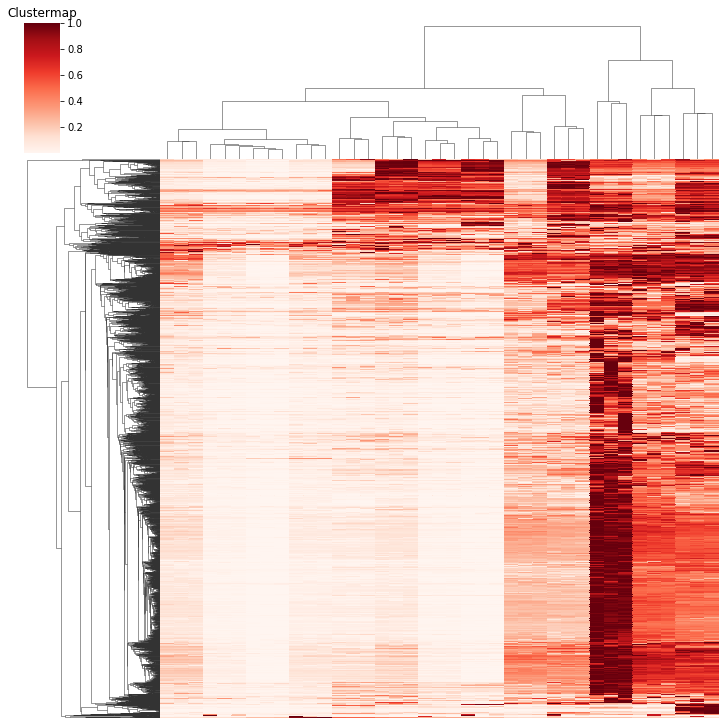

In [16]:
#no 0 is acceptable in the clustermap -- eye balling estimation?
sns.clustermap(d_norm.values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False)
plt.title('Clustermap')
plt.show()

# whole batch or only dilution series
whole batch to start with the testing, then apply extra filter to filter out cases, one exist both in source and non-source sample and etc.

In [15]:
#normalization of the dataset for statistical analysis -- unsupervised machine learning
#Q: is the normalization needed to terminate the effect of peak area variation?
#option: random forest, som, pca+k-means， t-sne+dbscan, autoencoder
#option2: non-parametric test
#Normalized data-c_data
d_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0.043773,0.016115,0.036778,0.057383,0.069410,0.062652,0.114069,0.103672,0.103696,0.108504,...,0.080197,0.153163,0.140391,0.133822,0.341320,0.320597,0.342348,0.684625,0.702205,0.666454
1,0.053719,0.021857,0.032772,0.038357,0.029917,0.029841,0.073454,0.026961,0.054098,0.071483,...,0.048110,0.056676,0.098317,0.055311,0.208687,0.262634,0.277087,0.436603,0.264504,0.567996
2,0.022368,0.010567,0.021370,0.012156,0.019877,0.013788,0.038669,0.028210,0.037681,0.043759,...,0.034675,0.075202,0.062766,0.042621,0.271490,0.164653,0.252118,0.360040,0.562095,0.351030
3,0.002092,0.001970,0.002784,0.020899,0.020606,0.021477,0.067364,0.067762,0.064329,0.087465,...,0.042137,0.106602,0.106790,0.111964,0.256398,0.251906,0.259326,0.571807,0.550691,0.554270
4,0.008626,0.003504,0.004953,0.005897,0.004953,0.006469,0.040805,0.042220,0.047577,0.085889,...,0.057787,0.090707,0.169520,0.151493,0.382573,0.403700,0.391637,0.717131,0.731047,0.710526


D:\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0, 0.5, 'mz')

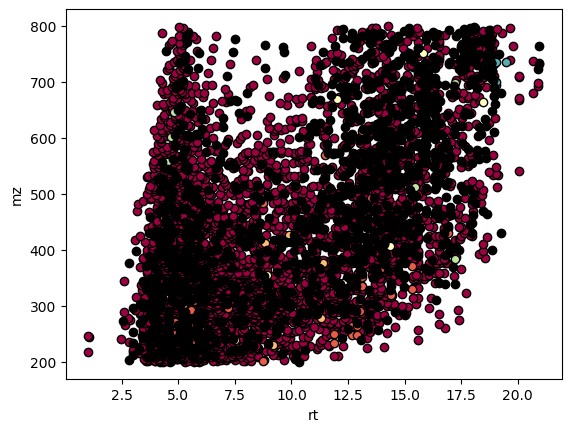

In [49]:
#Clustering visualization sample -- scatter plot
X=d_norm
#msfit = ms.fit(X)
db = DBSCAN(eps=0.9, min_samples=5).fit(X)

d_label = d_sample.iloc[d_norm.index]
d_label['label'] = db.labels_

#Plot
unique_labels = set(d_label['label'])
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        
    plt.plot(d_label[d_label['label']==k]['Average RT (min)'], d_label[d_label['label']==k]['Average m/z'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k')
    #plt.colorbar()
plt.xlabel('rt')
plt.ylabel('mz')

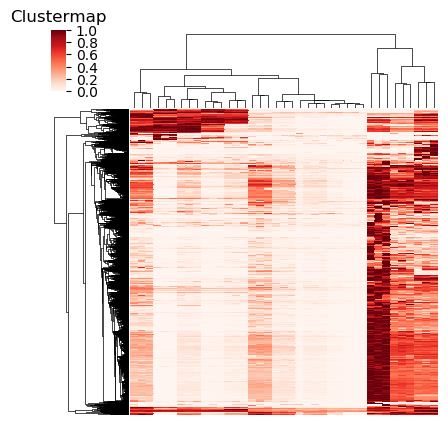

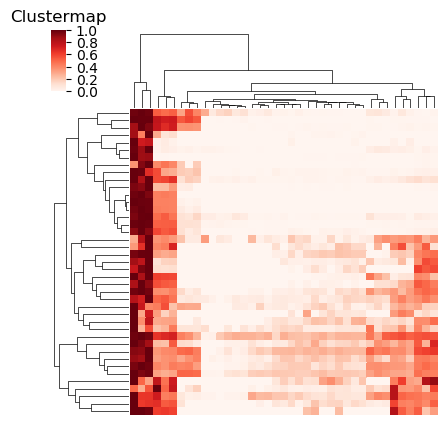

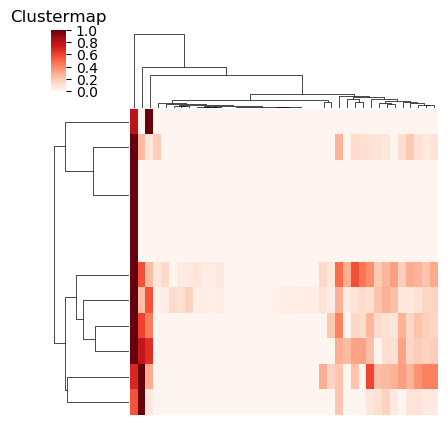

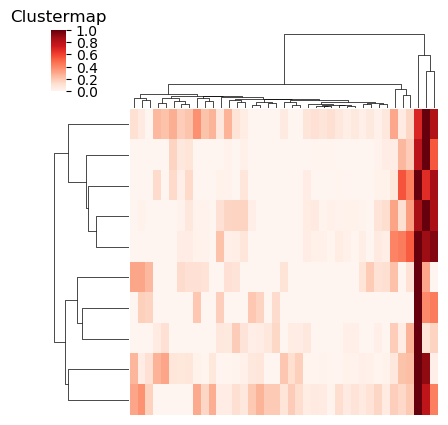

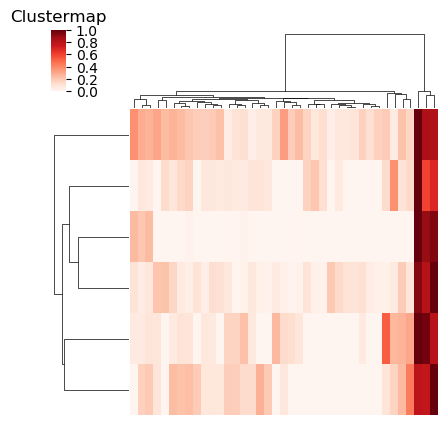

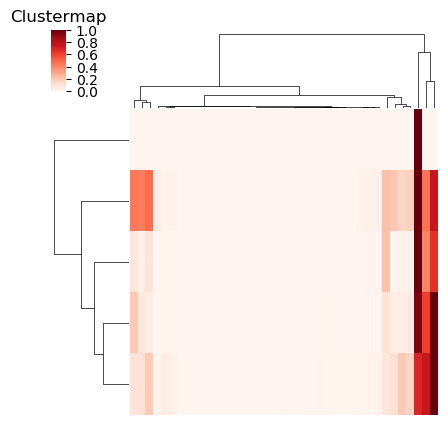

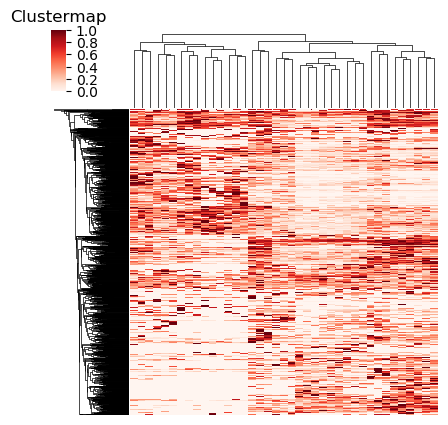

In [36]:
#Clustering visualization sample -- trend plot
X=d_norm.copy()
#msfit = ms.fit(X)
db = DBSCAN(eps=0.9, min_samples=5).fit(X)
labels = db.labels_

#Plot
unique_labels = set(db.labels_)

for i,k in enumerate(unique_labels):
    indexlist = list(np.argwhere(labels==k).reshape(1,-1)[0])
    sns.clustermap(X.iloc[indexlist].values,cmap='Reds',col_cluster=True,yticklabels=False,xticklabels=False,figsize=(5,5))
    plt.title('Clustermap')
    plt.show()

# Non-para testing ideas -- hypothesis testing
similar to alignment, compare row to row trend/statistical difference and then assign neighbours as same group

ref:https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

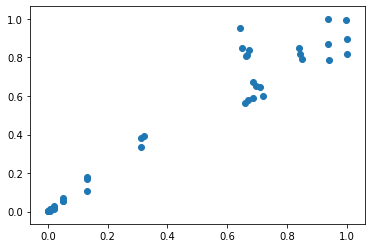

In [165]:
data1 = d_norm.iloc[1]
data2 = d_norm.iloc[500]
plt.scatter(d_norm.iloc[4], d_norm.iloc[400])

In [70]:
#Pearson’s Correlation Coefficient
from scipy.stats import pearsonr
count = 1
stat, p = pearsonr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    count += 1
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.068, p=0.681
Probably independent


In [71]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr
stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.761, p=0.000
Probably dependent


In [79]:
# Example of the Kendall's Rank Correlation Test
from scipy.stats import kendalltau
stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.506, p=0.000
Probably dependent


In [81]:
# Example of the Chi-Squared Test
from scipy.stats import chi2_contingency
table = [data1,data2]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=3.351, p=1.000
Probably independent


In [82]:
# Example of the Mann-Whitney U Test --check for distribution
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=2369.500, p=0.000
Probably different distributions


In [83]:
# Example of the Kruskal-Wallis H Test
from scipy.stats import kruskal
stat, p = kruskal(data1, data2)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=24.836, p=0.000
Probably different distributions


In [ ]:
comparing data_pairwise
if they are similar --> assign to cluster
elif not --> assign a new clutser

similar to alignment, do we wanna update the cluster information?

In [ ]:
#comparison plot -- different algorithm with clustering result as color label in the mz/rt scatter plot
#Post filter--some cpd show up in dilution but not other samples, and vice versa
#Prediction model based on clustering information